# Fitting Unknown Rp to Process Data

In [1]:
# Since this is running in a Jupyter notebook, need to help it find LyoPRONTO
# For the documentation, the path is nearby.
# If you have already installed LyoPRONTO as a Python package,
# this should be unnecessary.
import sys
sys.path.append('../../')

In [2]:
from scipy.optimize import curve_fit
import numpy as np
import csv
import matplotlib.pyplot as plt
from matplotlib import rc as matplotlibrc
import time

# from lyopronto.calc_unknownRp import dry

from lyopronto import *

In [3]:


################################################################

######################## Inputs ########################

sim = dict([('tool','Primary Drying Calculator'),('Kv_known','Y'),('Rp_known','N'),('Variable_Pch','N'),('Variable_Tsh','N')])

# Vial and fill properties
# Av = Vial area in cm^2
# Ap = Product Area in cm^2
# Vfill = Fill volume in mL
vial = dict([('Av',3.80),('Ap',3.14),('Vfill',2.0)])

#Product properties
# cSolid = Fractional concentration of solute in the frozen solution
# Tpr0 = Initial product temperature for freezing in degC
# Tf = Freezing temperature in degC
# Tn = Nucleation temperature in degC
# Product Resistance Parameters
# R0 in cm^2-hr-Torr/g, A1 in cm-hr-Torr/g, A2 in 1/cm
product = dict([('cSolid',0.05)])
# Critical product temperature
# At least 2 to 3 deg C below collapse or glass transition temperature
product['T_pr_crit'] = -5        # in degC

# Vial Heat Transfer Parameters
# Kv = KC + KP*Pch/(1+KD*Pch) 
# KC in cal/s/K/cm^2, KP in cal/s/K/cm^2/Torr, KD in 1/Torr
ht = dict([('KC',2.75e-4),('KP',8.93e-4),('KD',0.46)])

# Chamber Pressure
Pchamber = dict([('setpt',[0.15]),('dt_setpt',[1800.0]),('ramp_rate',0.5)])

# Shelf Temperature
# init = Intial shelf temperature in C
# setpt = Shelf temperature set points in C
# dt_setpt = Time for which shelf temperature set points are held in min
# ramp_rate = Shelf temperature ramping rate in C/min
Tshelf = dict([('init',-35.0),('setpt',[20.0]),('dt_setpt',[1800.0]),('ramp_rate',1.0)])

# Time step
dt = 0.01    # hr

# Lyophilizer equipment capability
# Form: dm/dt [kg/hr] = a + b * Pch [Torr]
# a in kg/hr, b in kg/hr/Torr 
eq_cap = dict([('a',-0.182),('b',0.0117e3)])

# Equipment load
nVial = 398    # Number of vials



To estimate $R_p$, we need to provide experimentally measured temperatures. The format preferred by the web interface is a CSV with no headers, time in hours in the first column, and temperature in degrees Celsius in the second column.

If you are loading these yourself in a script, you should provide it with those units, but you can load it from whatever file makes sense and simply provide it to the call to `calc_unknownRp.dry` below.

In [4]:
product_temp_filename = './temperature.txt'
dat = np.loadtxt(product_temp_filename)
time = dat[:,0]
Tbot_exp = dat[:,1]


The call to `calc_unkonwRp.dry` provides an array of simulation output, as well as an array with time, dry layer height, and $R_p$ in the three columns. 

In [5]:

output_table, product_res = calc_unknownRp.dry(vial,product,ht,Pchamber,Tshelf,time,Tbot_exp)


The web interface simply feeds the computed resistance vs dry layer height to SciPy's `scipy.optimize.curve_fit` in order to estimate the simple nonlinear form:
$$ R_p = R_0 + \frac{A_1 l}{1 + A_2 l} $$

In [7]:

params,params_covariance = curve_fit(lambda h,r,a1,a2: r+h*a1/(1+h*a2),product_res[:,1],product_res[:,2],p0=[1.0,0.0,0.0])
print("R0 = "+str(params[0])+"\n")
print("A1 = "+str(params[1])+"\n")
print("A2 = "+str(params[2])+"\n")
#################

##########################


R0 = 0.02089279322037721

A1 = 7.843317942227547

A2 = 0.5081399451752311



In [8]:

# LaTeX setup
matplotlibrc('text.latex', preamble=r'\usepackage{color}')
matplotlibrc('text',usetex=False)
matplotlibrc('font',family='Arial')

figwidth = 30
figheight = 20
lineWidth = 5
markerSize = 20

The web interface is not currently set up to show the following graph, but it is absolutely worth checking what the fit looks like in $R_p$ space.

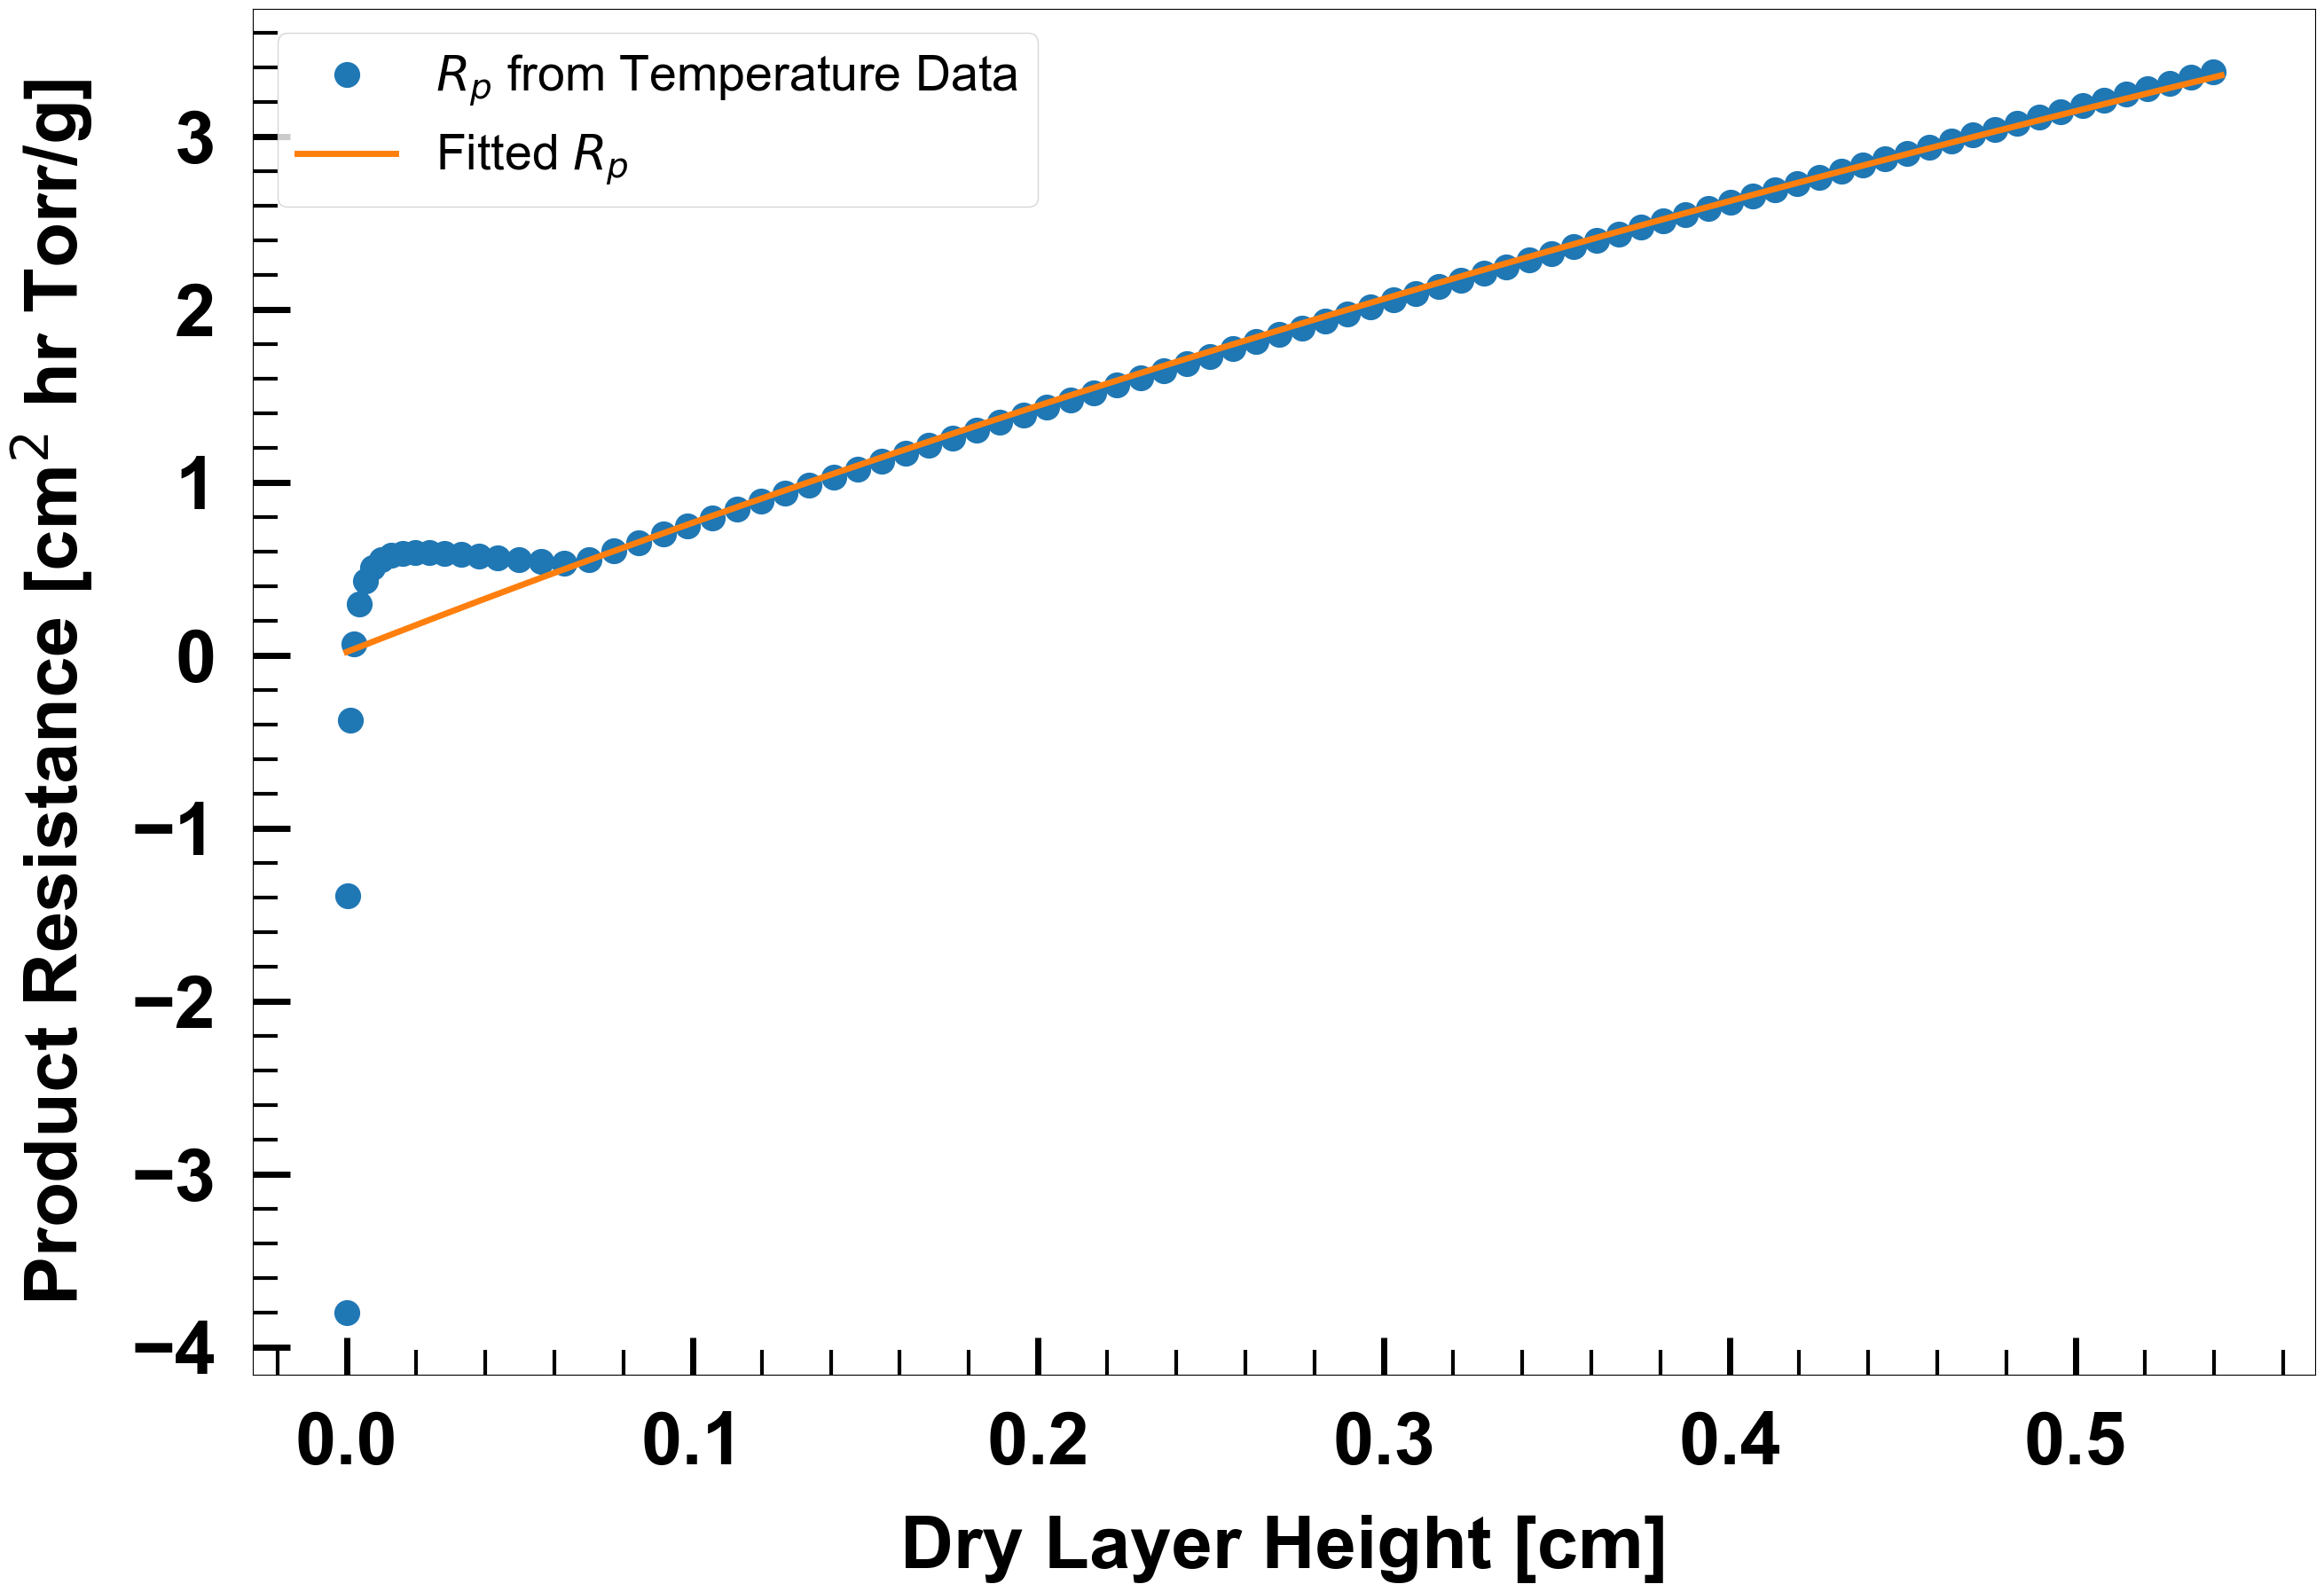

In [9]:
fig = plt.figure(0,figsize=(figwidth,figheight))
ax = fig.add_subplot(111)
plot_styling.axis_style_rp(ax)
ax.plot(product_res[:,1],product_res[:,2],'o', markevery=5, markersize=markerSize,label='$R_p$ from Temperature Data')
ax.plot(product_res[:,1],params[0]+product_res[:,1]*params[1]/(1+product_res[:,1]*params[2]),'-',linewidth=lineWidth,label='Fitted $R_p$')
plt.legend(fontsize=40, loc='best')

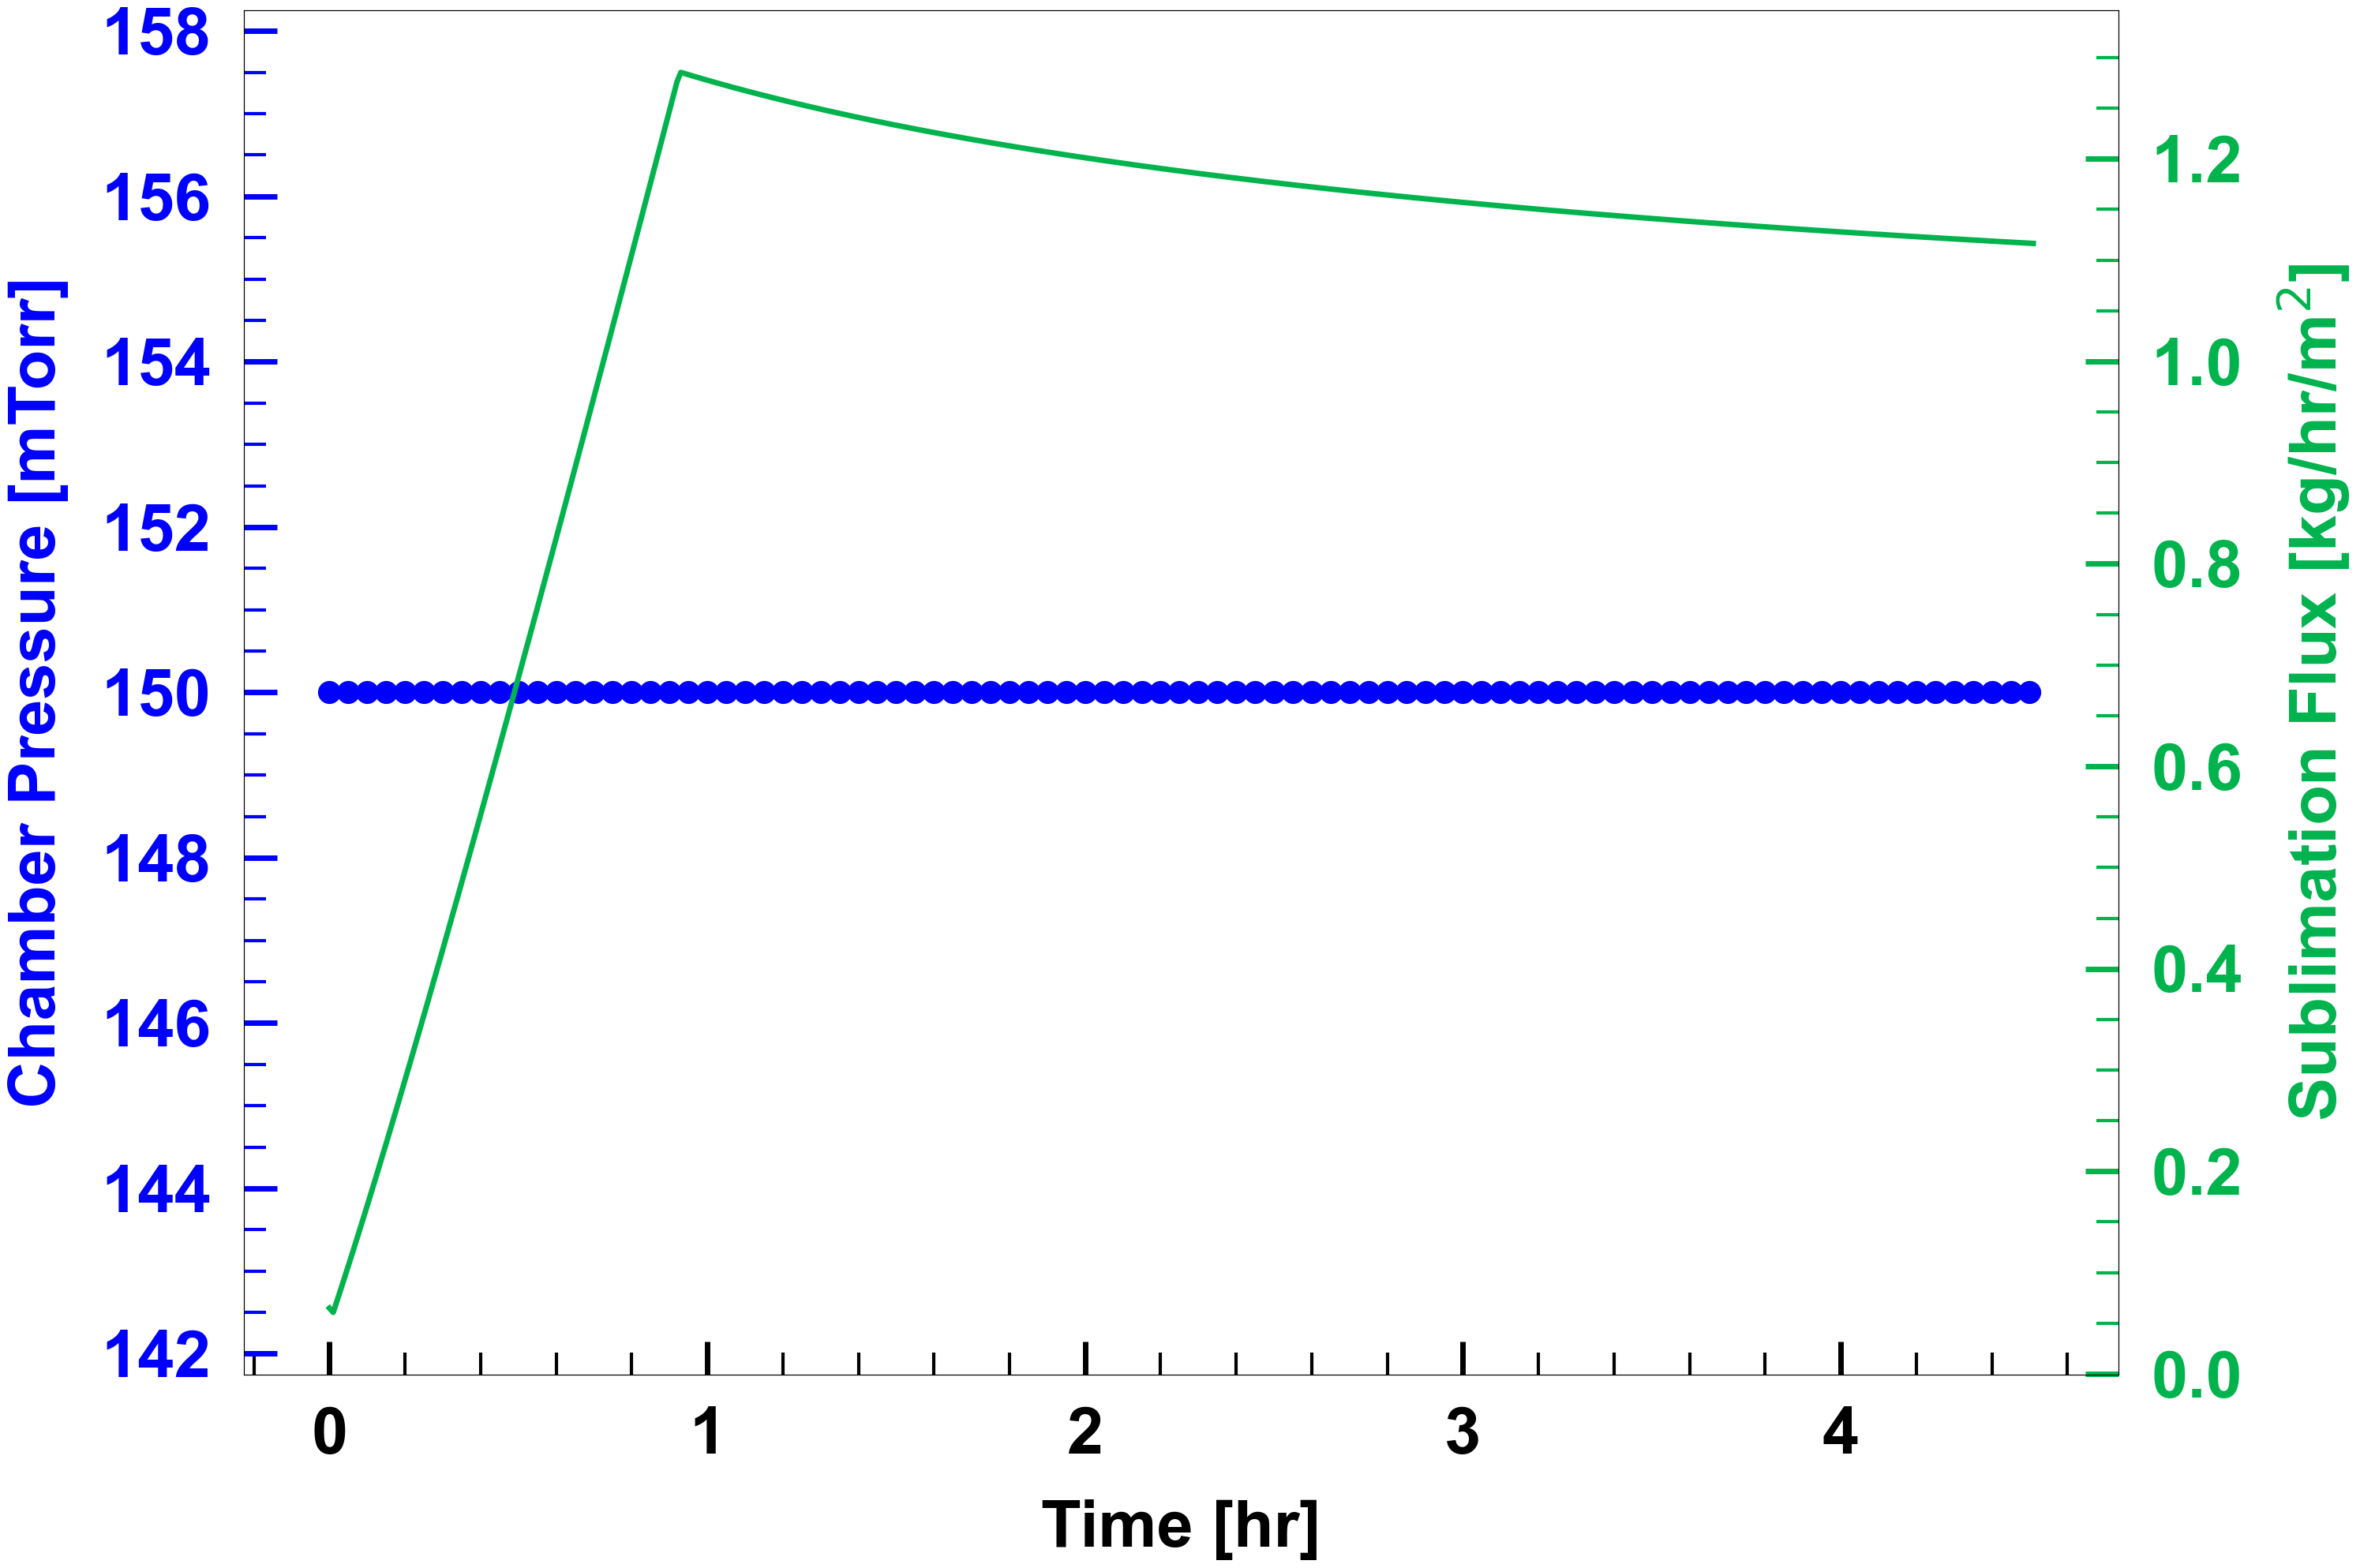

In [10]:

fig = plt.figure(0,figsize=(figwidth,figheight))
ax1 = fig.add_subplot(1,1,1)
ax2 = ax1.twinx()
ax1.plot(output_table[:,0],output_table[:,4],'-o',color='b',markevery=5,linewidth=lineWidth, markersize=markerSize, label = "Chamber Pressure")
ax2.plot(output_table[:,0],output_table[:,5],'-',color=[0,0.7,0.3],linewidth=lineWidth, label = "Sublimation Flux")

plot_styling.axis_style_pressure(ax1)
plot_styling.axis_style_subflux(ax2)

plt.tight_layout()

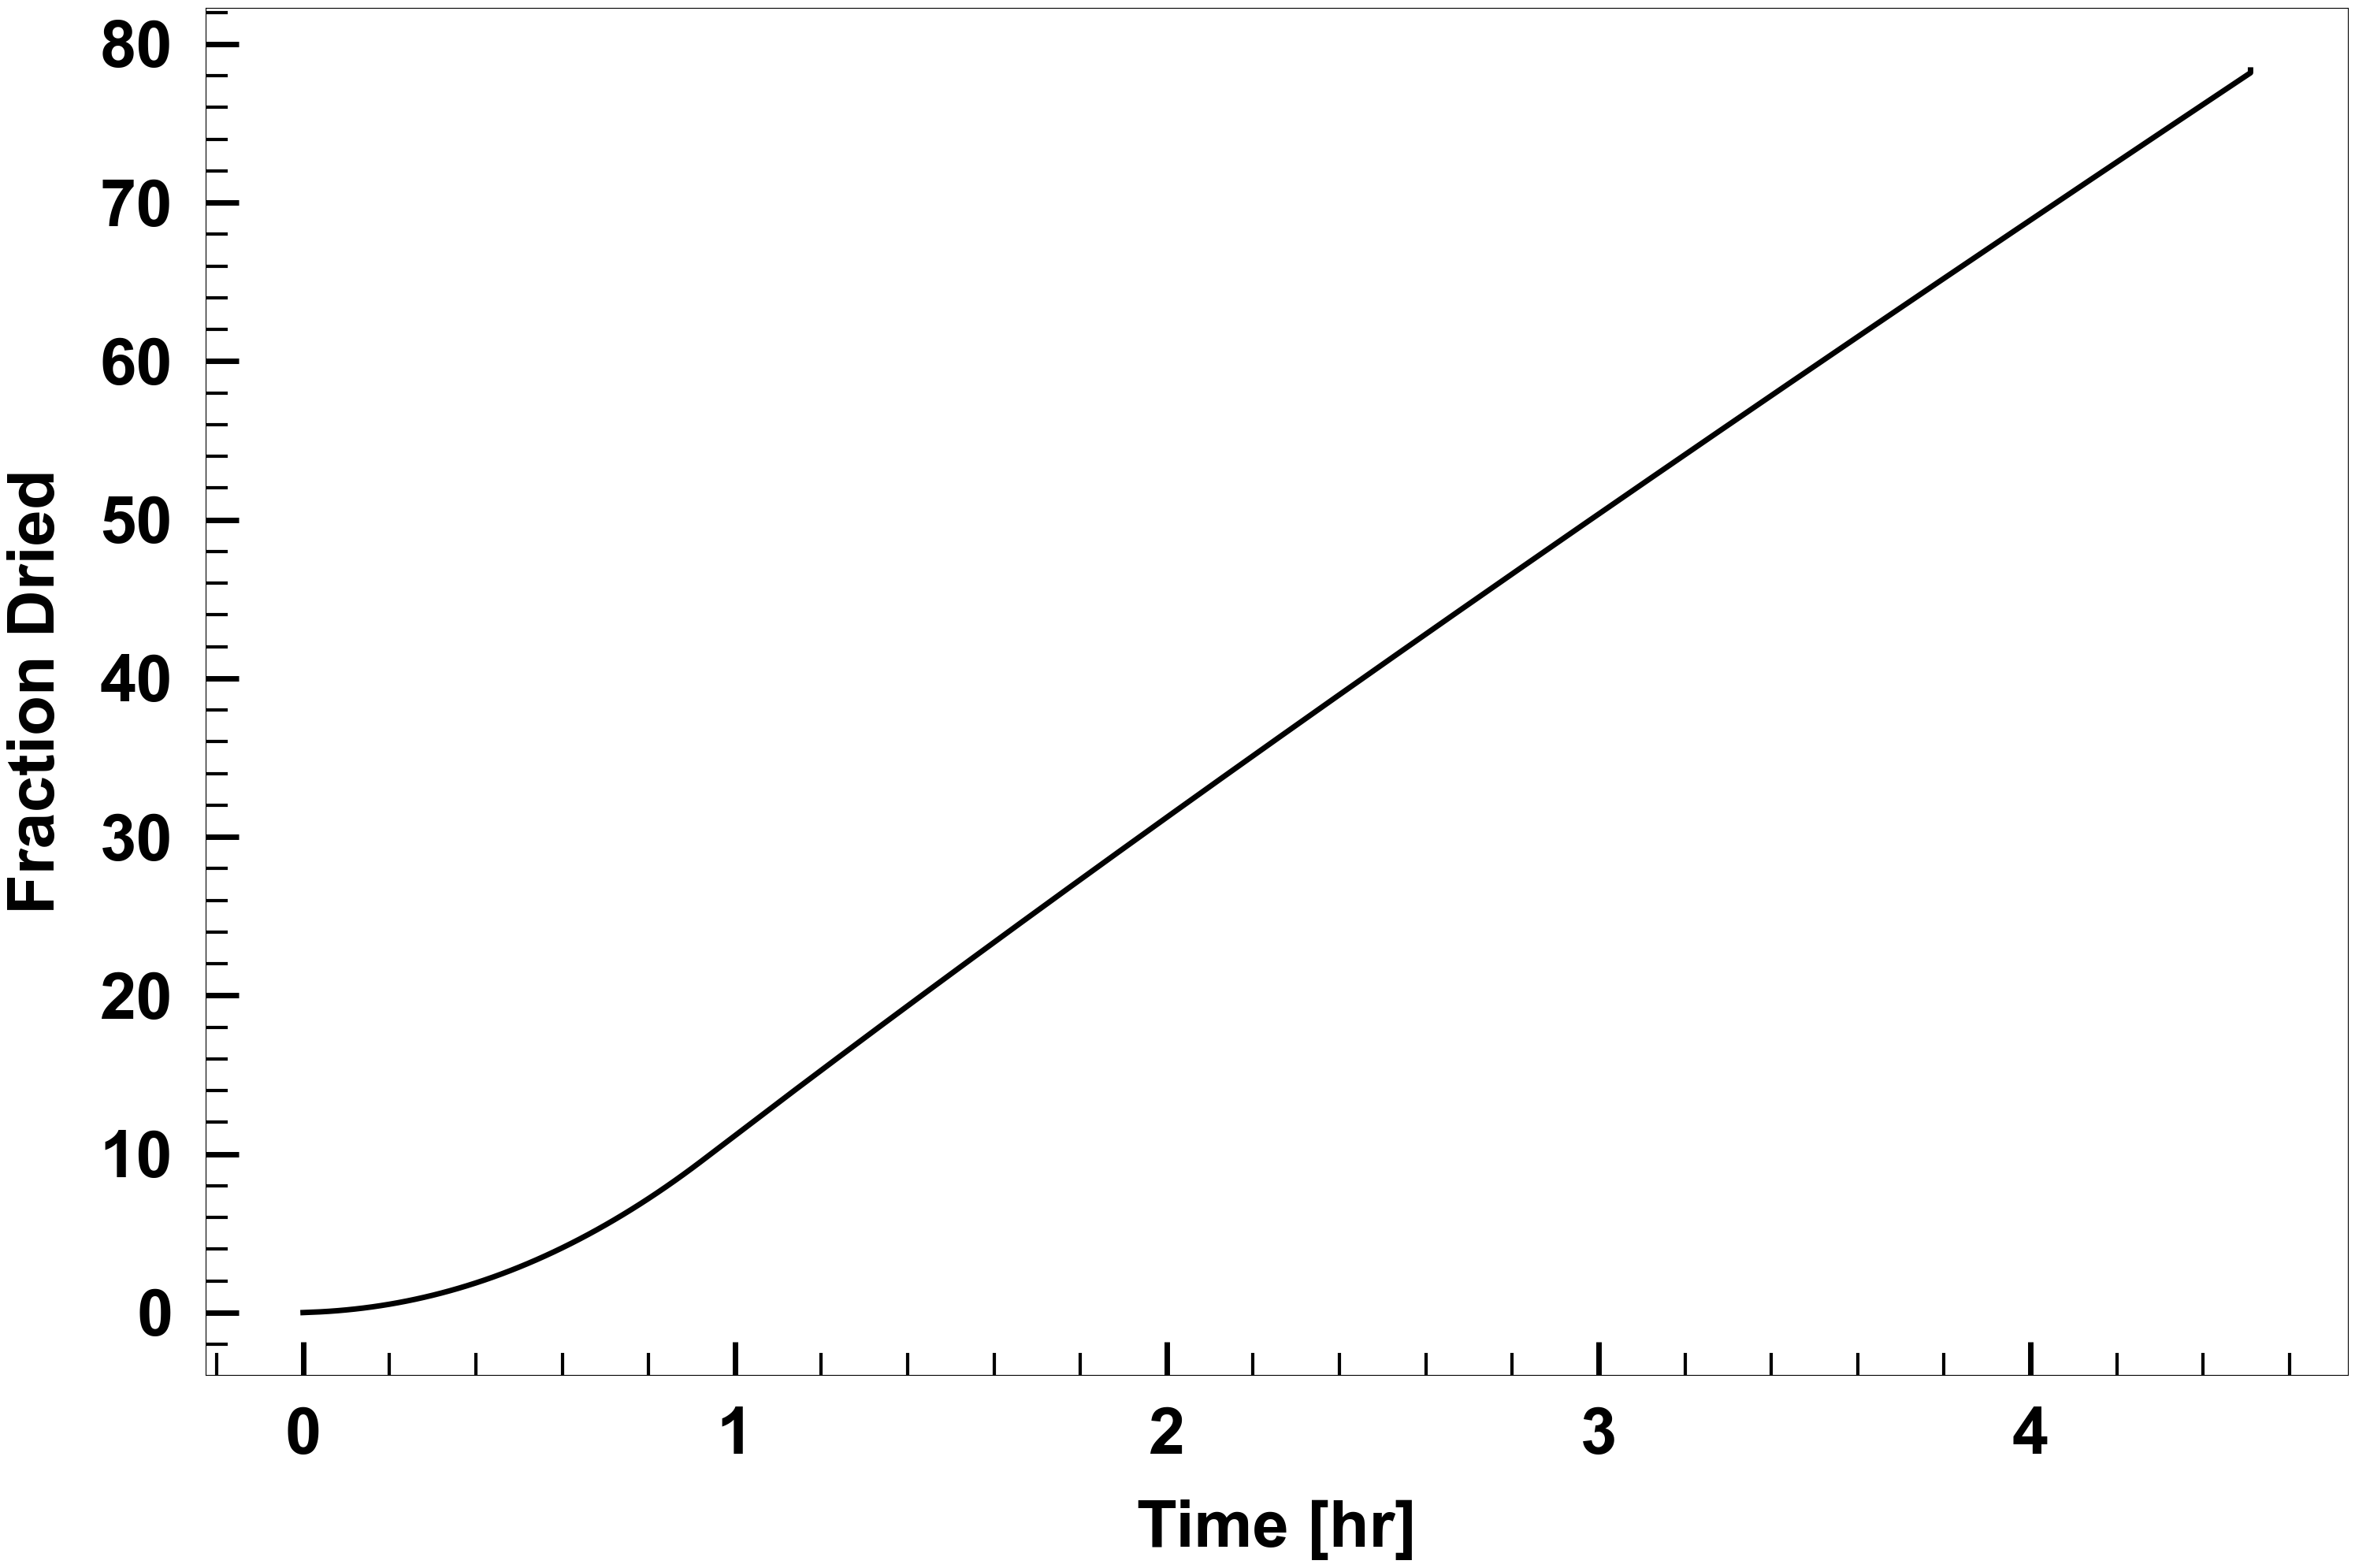

In [11]:

fig = plt.figure(0,figsize=(figwidth,figheight))
ax = fig.add_subplot(1,1,1)
plot_styling.axis_style_percdried(ax)
ax.plot(output_table[:,0],output_table[:,-1],'-k',linewidth=lineWidth, label = "Percent Dried")
plt.tight_layout()
# figure_name = 'lyopronto_percentdried_'+current_time+'.pdf'
# plt.savefig(figure_name)
# plt.close()


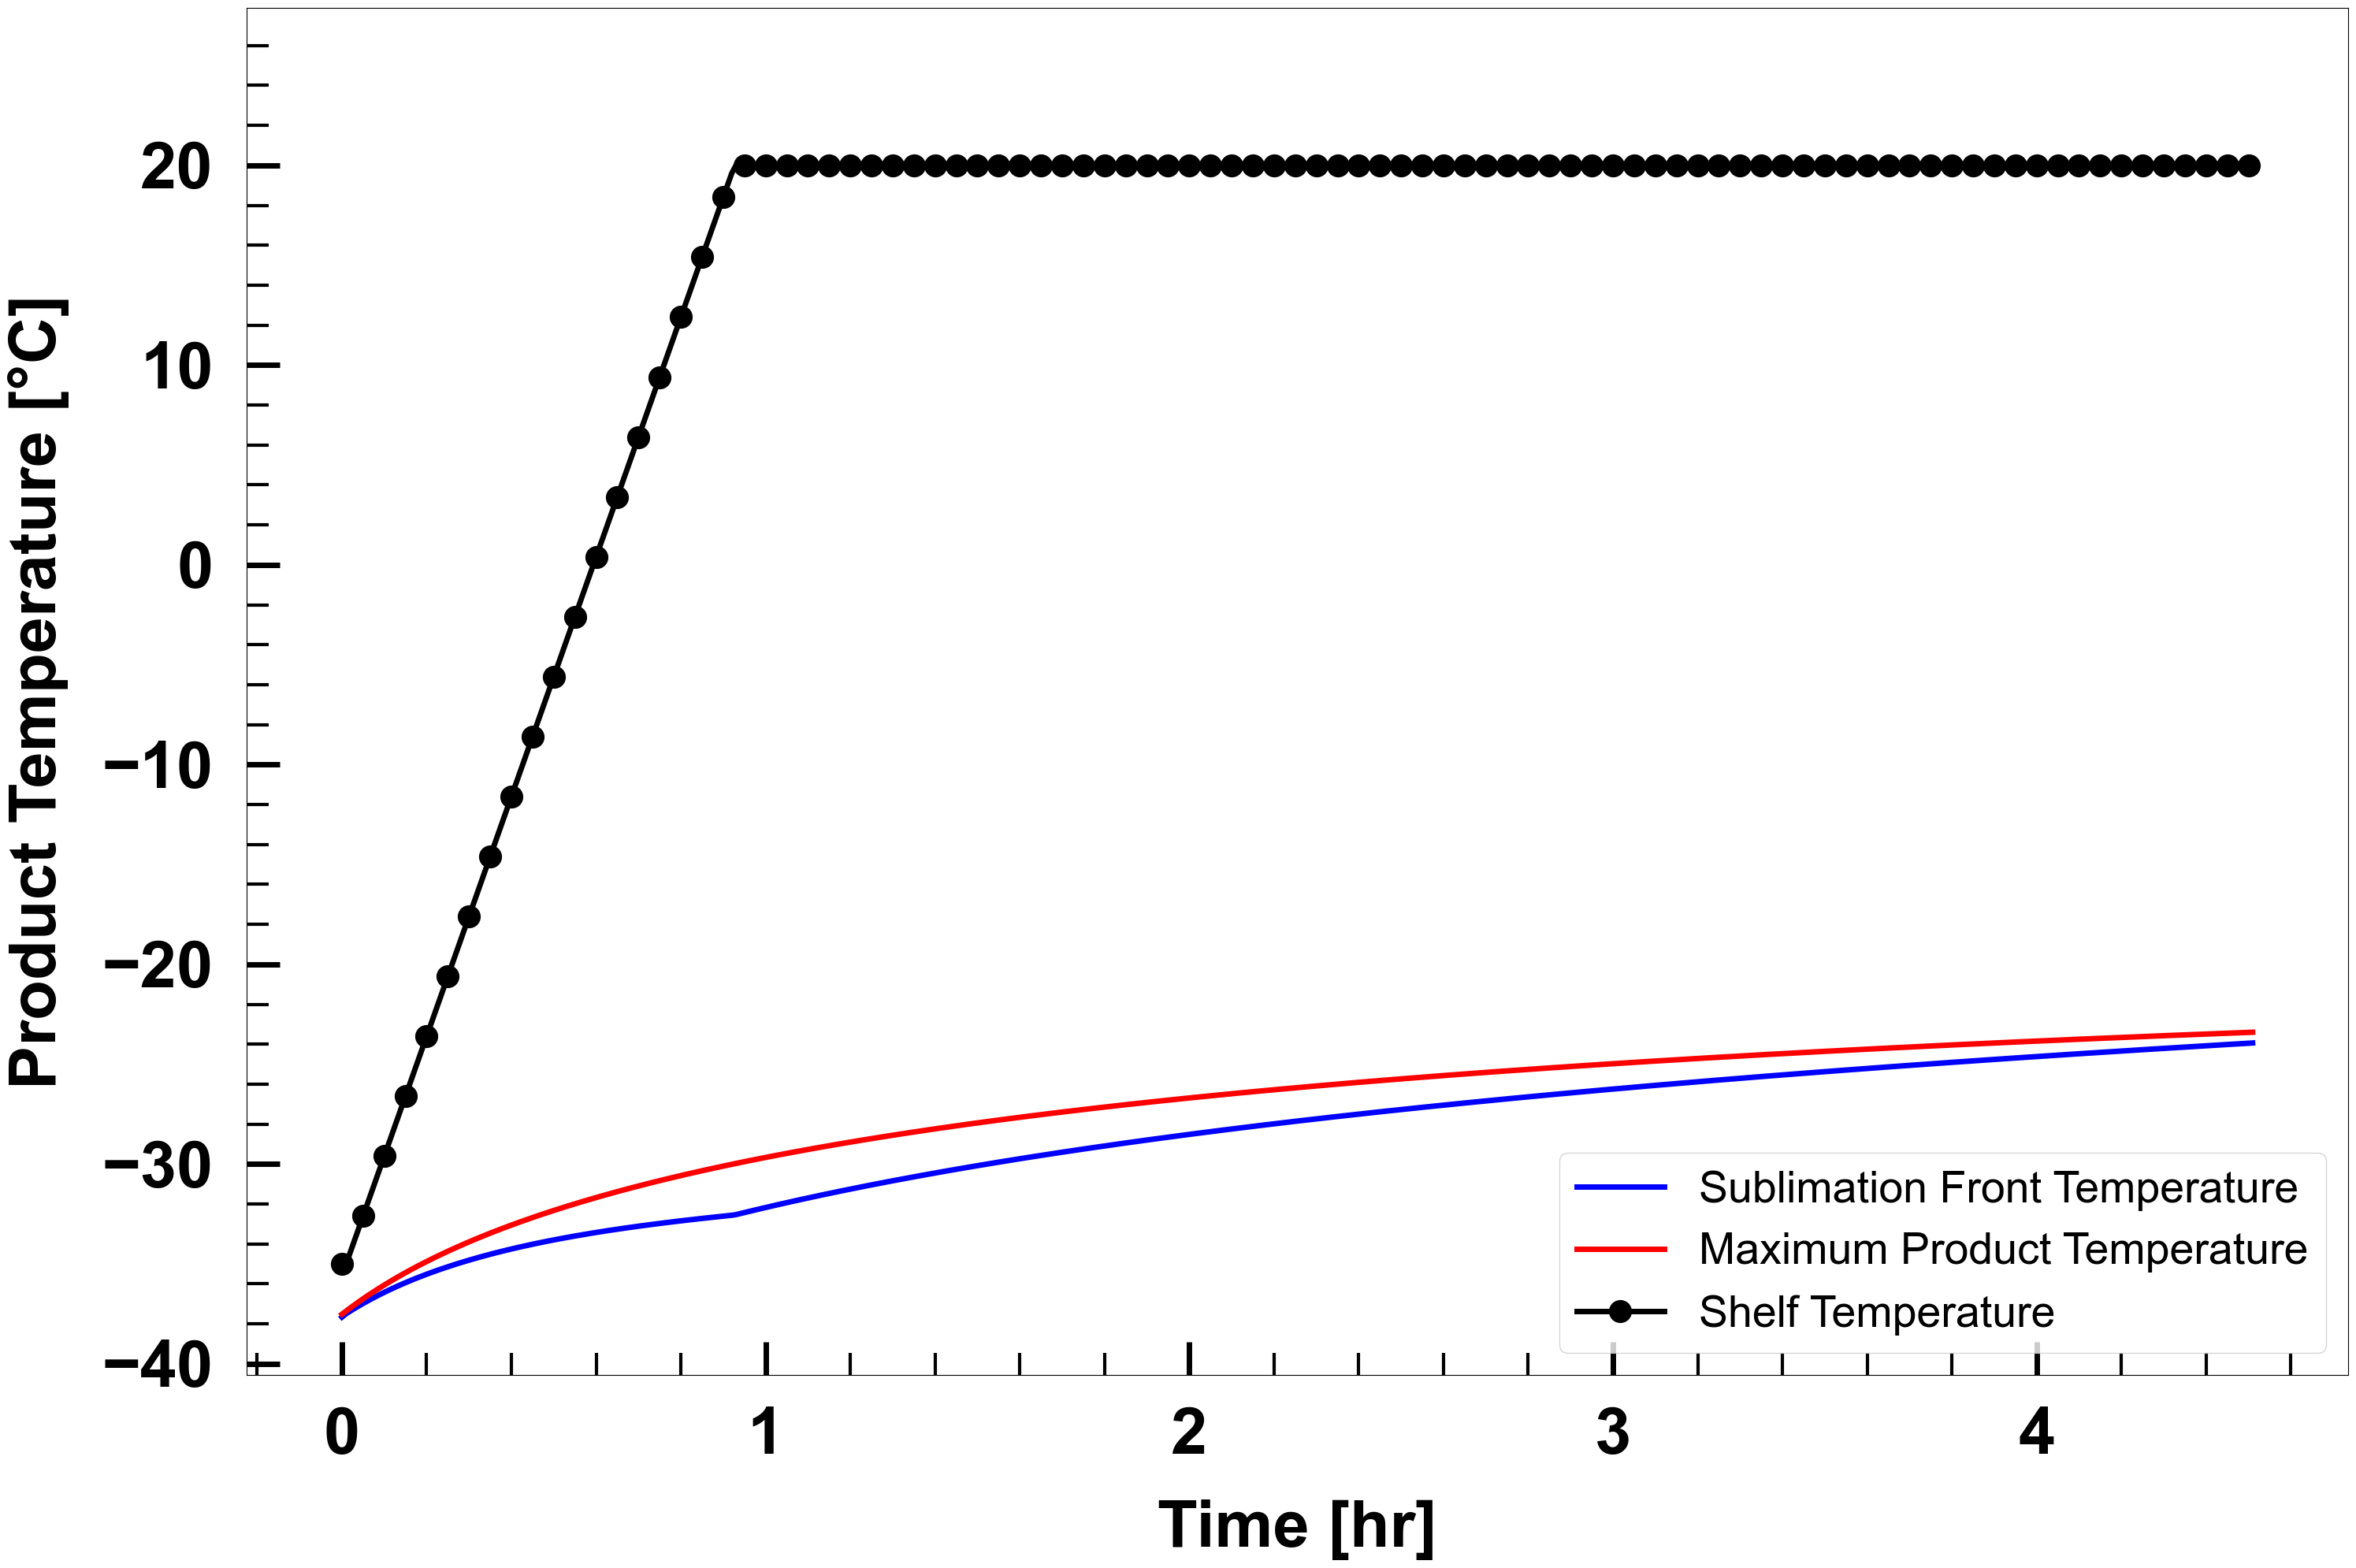

In [12]:

fig = plt.figure(0,figsize=(figwidth,figheight))
ax = fig.add_subplot(1,1,1)
plot_styling.axis_style_temperature(ax)
ax.plot(output_table[:,0],output_table[:,1],'-b',linewidth=lineWidth, label = "Sublimation Front Temperature")
ax.plot(output_table[:,0],output_table[:,2],'-r',linewidth=lineWidth, label = "Maximum Product Temperature")
ax.plot(output_table[:,0],output_table[:,3],'-o',color='k',markevery=5,linewidth=lineWidth, markersize=markerSize, label = "Shelf Temperature")
plt.legend(fontsize=40,loc='best')
ll,ul = ax.get_ylim()
ax.set_ylim([ll,ul+5.0])
plt.tight_layout()
# figure_name = 'lyopronto_temperatures_'+current_time+'.pdf'
# plt.savefig(figure_name)
# plt.close()